<a href="https://colab.research.google.com/github/camilealheiro/Ovos-VC/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torchvision import models
import os
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import VGG16_Weights
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, transform
from PIL import Image
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
class EggShellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('L')
        measurements = self.data_frame.iloc[idx, 1:].values.astype('float')
        sample = {'image': image, 'measurements': measurements}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# train_dataset = EggShellDataset(csv_file='imagem/train.csv', root_dir='imagem/', transform=data_transform)
# test_dataset = EggShellDataset(csv_file='imagem/test.csv', root_dir='imagem/', transform=data_transform)

train_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Ovos segmentados 2 rodada/imagens/train.csv', root_dir='/content/drive/MyDrive/Ovos segmentados 2 rodada/', transform=data_transform)
test_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Ovos segmentados 2 rodada/imagens/test.csv', root_dir='/content/drive/MyDrive/Ovos segmentados 2 rodada/', transform=data_transform)

# Definindo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.conv = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

        # Substituir a primeira camada convolucional para aceitar um canal (escala de cinza)
        self.conv[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 28) # mudar a saida conforme o número de eaturea a serem previstas
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
model = CNNRegression()

# Definindo a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNRegression(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [ ]:
def adjusted_r2(y_test, y_pred, X_train):
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) /
              (len(y_test) - X_train.shape[1] - 1))
    return adj_r2

In [ ]:
num_epochs = 10

train_losses = []
train_r2_scores = []
train_rmse_scores = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'].to(device), data['measurements'].to(device)
        inputs = inputs[:,:1,:,:]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

print('Finished Training')

Epoch [1/10], Loss: 94.310791015625
Epoch [2/10], Loss: 44.36404037475586
Epoch [3/10], Loss: 113.1375503540039
Epoch [4/10], Loss: 2530235.0
Epoch [5/10], Loss: 42.02024841308594
Epoch [6/10], Loss: 94.53836822509766
Epoch [7/10], Loss: 52.66114807128906
Epoch [8/10], Loss: 1846.036865234375
Epoch [9/10], Loss: 162.54798889160156
Epoch [10/10], Loss: 54.949066162109375
Finished Training


In [ ]:
num_epochs = 10

test_losses = []
test_r2_scores = []
test_rmse_scores = []

for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
      y_true = []
      y_pred = []
      test_loss = 0

      for data in test_loader:
          inputs, labels = data['image'].to(device).float(), data['measurements'].to(device).float()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          test_loss += loss.item()

          y_true.extend(labels.cpu().numpy())
          y_pred.extend(outputs.cpu().numpy())

      y_true = np.concatenate(y_true, axis=0)
      y_pred = np.concatenate(y_pred, axis=0)
      test_loss /= len(test_loader)

      rmse = np.sqrt(mean_squared_error(y_true, y_pred))
      r2 = r2_score(y_true, y_pred)

      # Armazena as métricas para plotagem posterior
      test_losses.append(test_loss)
      test_r2_scores.append(r2)
      test_rmse_scores.append(rmse)

      print(f'Test Loss after Epoch [{epoch+1}/{num_epochs}]: {test_loss}')
      print(f'RMSE: {rmse}, R²: {r2}')


Test Loss after Epoch [1/10]: 41.73140013845343
RMSE: 6.441989421844482, R²: 0.9029425482116704
Test Loss after Epoch [2/10]: 41.41664003071032
RMSE: 6.441989421844482, R²: 0.9029425482598014
Test Loss after Epoch [3/10]: 41.424489874588815
RMSE: 6.441989421844482, R²: 0.9029425483190668
Test Loss after Epoch [4/10]: 41.48986414859169
RMSE: 6.441989421844482, R²: 0.9029425481771383
Test Loss after Epoch [5/10]: 41.66325077257658
RMSE: 6.441989421844482, R²: 0.9029425465243148
Test Loss after Epoch [6/10]: 41.750863326223275
RMSE: 6.441989898681641, R²: 0.9029425499721391
Test Loss after Epoch [7/10]: 41.50684236225329
RMSE: 6.441989421844482, R²: 0.9029425480813749
Test Loss after Epoch [8/10]: 41.368487307899876
RMSE: 6.441989898681641, R²: 0.9029425482670964
Test Loss after Epoch [9/10]: 41.34676632128264
RMSE: 6.441989421844482, R²: 0.9029425482280762
Test Loss after Epoch [10/10]: 41.48326713160465
RMSE: 6.441989898681641, R²: 0.9029425469676958


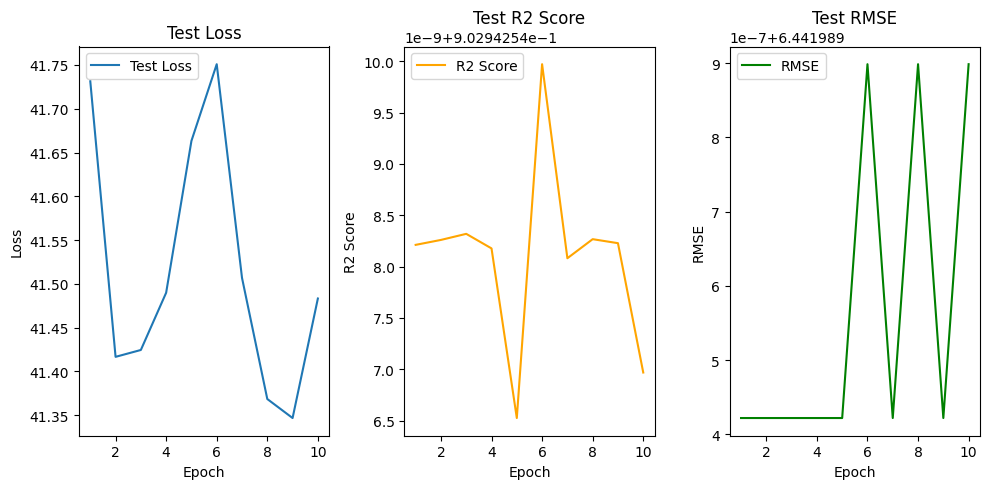

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plotando a perda
plt.subplot(1, 3, 1)
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Plotando o R2 score ajustado
plt.subplot(1, 3, 2)
plt.plot(epochs, test_r2_scores, label='R2 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Test R2 Score')
plt.legend()

# Plotando o RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, test_rmse_scores, label='RMSE', color='green')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()

plt.tight_layout()
plt.show()